# Pre-stretched electro-elastic actuation

-  Code for 3D large deformation electro-elasticity with u-p formulation

- Electro-elastic instability suppresion study on a circular VHB membrane
- Uses quadrature representation of internal variable: viscous deformation tensor Cv.
- VHB material properties taken from Wang et al., JMPS (2016).

### Units
- Length: mm
- Mass: kg  
- Time:  s
- Charge: nC
- Force: mN
- Stress: kPa 
- Energy: microJ
- Electric potential: kV

### Software:
- Dolfinx v0.8.0

# Import modules

In [27]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, acos, ge, le, outer)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [28]:
# A 2-D box with square cross-section
preStretch = 4.0 # equi-biaxial pre-stretch for the film
# 
# We choose reference length and electrode radius so that the 
# spatial electrode radius is ~2.5mm as in Pelrine et al. (2000), and 
# the spatial overall radius is 10mm (with a pre-stretch of 4).
#
length     = 10/preStretch  # 2.5  # undeformed radius, mm
electrode  = length/3 # 0.825 # undeformed radius, mm
#
# the reference thickness is known, 200 um is standard for 3M VHB adhesive tape.
thickness  = 0.2 # undeformed thickness, mm
# thickness  = 1.0 # undeformed thickness, mm

domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0.0,0.0], [length,thickness]],\
                         [100,2], mesh.CellType.triangle, diagonal=mesh.DiagonalType.crossed)

x = ufl.SpatialCoordinate(domain)

In [29]:
# Identify the planar boundaries of the  box mesh
#
def Left(x):
    return np.isclose(x[0], 0.0)
def Right(x):
    return np.isclose(x[0], length)
def Top(x):
    return np.isclose(x[1], thickness)
def Bottom(x):
    return np.isclose(x[1], 0.0)
def BotLeft(x):
    return np.logical_and(np.isclose(x[1], 0.0), np.isclose(x[0], 0.0))
def TopElectrode(x):
    return np.logical_and(np.isclose(x[1],thickness), np.less_equal(x[0],electrode))
def BotElectrode(x):
    return np.logical_and(np.isclose(x[1],0), np.less_equal(x[0],electrode))
def TopNotElectrode(x):
    return np.logical_and(np.isclose(x[1],thickness), np.greater(x[0],electrode))
def BotNotElectrode(x):
    return np.logical_and(np.isclose(x[1],0), np.greater(x[0],electrode))
     

# Mark the sub-domains
boundaries = [(1,Left),(2,Bottom),(3,Right),(4,Top),(5,TopElectrode),(6,BotElectrode),\
    (7,TopNotElectrode),(8,BotNotElectrode)]

# Build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [30]:
# top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
# values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
# values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[1 2 3 4 5 6 7 8]


**Visualize reference configuration and boundary facets**

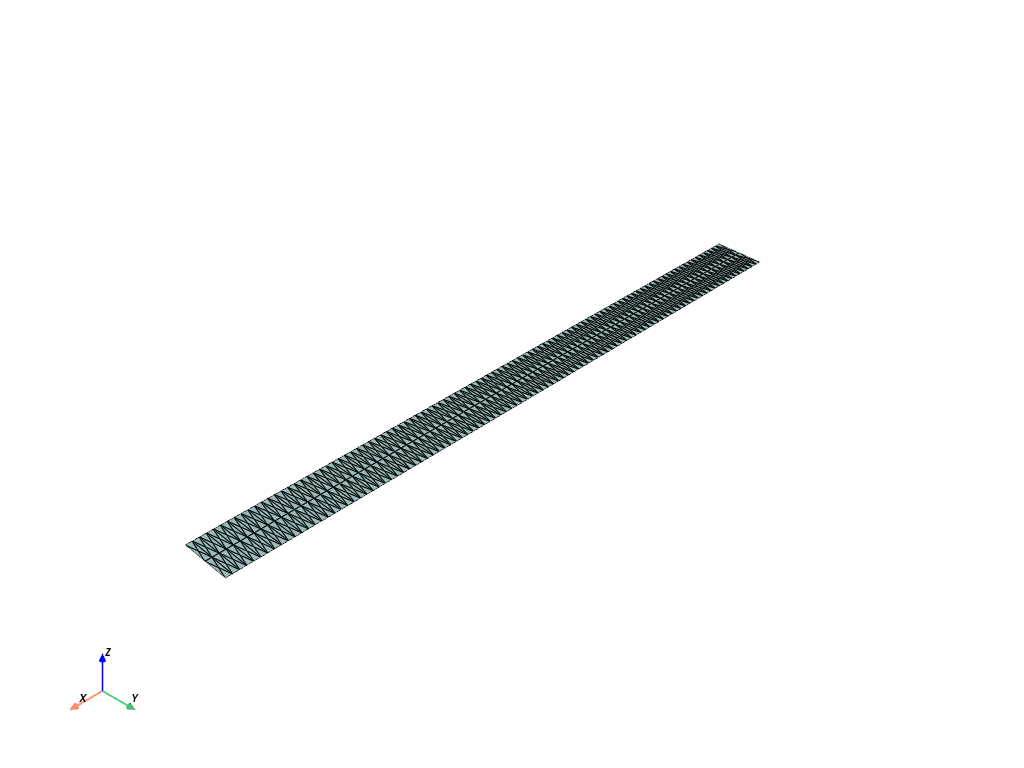

In [31]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()


# LeftFace = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==1]) )
# RightFace = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==3]) )
# TopFace = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==4]) )
# BotFace = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==2]) )

# actor  = plotter.add_mesh(LeftFace, show_edges=True,color="purple")
# actor1 = plotter.add_mesh(RightFace, show_edges=True,color="blue")
# actor2 = plotter.add_mesh(TopFace, show_edges=True,color="red")
# actor3 = plotter.add_mesh(BotFace, show_edges=True,color="green")


# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/membrane_mesh.png")

from IPython.display import Image
Image(filename='results/membrane_mesh.png') 

### Un-comment this cell to see an interactive visualization of the mesh

In [32]:
# plotter.show()

## Define boundary and volume integration measure

In [33]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parameters

In [34]:
# Equilibrium material parameters
#
rho = Constant(domain, PETSc.ScalarType(1e-6))           # 1000 kg/m^3 = 1e-6 kg/mm^3
#
Geq_0   = Constant(domain, PETSc.ScalarType(15.36))      # Shear modulus, kPa
Kbulk   = Constant(domain, PETSc.ScalarType(1e3*Geq_0))  # Bulk modulus, kPa
lambdaL = Constant(domain, PETSc.ScalarType(5.99))        # Arruda-Boyce locking stretch

# Electrostatic  parameters
vareps_0 = Constant(domain, PETSc.ScalarType(8.85E-3)) #  permittivity of free space pF/mm
vareps_r = Constant(domain, PETSc.ScalarType(4.8))     #  relative permittivity, dimensionless
vareps   = vareps_r*vareps_0         #  permittivity of the material

# Simulation time-control related params

In [35]:
# start time (sec)
t = 0.0

# Step 1 is a prestretch
dispRate    = 1e-3 # mm/sec 
dispTot     = length*(preStretch-1)
step1_time  = dispTot/dispRate
num_steps1  = 25
dt1         = step1_time/num_steps1 


# Step 2 is electro-actuation
# rampRate    = 1e-3
# step2_time  = 1/rampRate
step2_time  = 1.0
num_steps2  = 300
dt2         = step2_time/num_steps2 

# assign the time step for step 1
dt = dt1
dk = Constant(domain, PETSc.ScalarType(dt))

# Normalization parameter for voltage is l*sqrt(Geq_0/vareps)
#
phiTot = 0.3*float(thickness*np.sqrt(float(Geq_0)/float(vareps)))  # final normalized value of phi
# for t = 0.2mm, this works out to be a few kV, same as in the experiments of Pelrine et al. (2000).

# Boundary condition functions
def DispRamp(t):
    if t<=step1_time:
        disp = dispTot*t/step1_time
    else:
        disp = dispTot
    return disp

def PhiRamp(t):
    if t<= step1_time:
        phi = 0.0
    else:
        phi = phiTot*(t-step1_time)/step2_time
    return phi

# Function spaces

In [36]:

U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,))  # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For pressure and electric potential
#
TH = mixed_element([U2, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P1) # Scalar function space.
V2 = functionspace(domain, U2) # Vector function space
#
# Define actual functions with the required DOFs
w = Function(ME)
u, p, phi = split(w) # displacement u, presssure p, and electric potential phi

# A copy of functions to store values in the previous step
w_old  = Function(ME)
u_old, p_old, phi_old = split(w_old)   

# Define test functions   
u_test, p_test, phi_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)


# # Initial conditions: 

# # A function for constructing the identity matrix.
# #
# # To use the interpolate() feature, this must be defined as a 
# # function of x.
# def identity(x):
#     values = np.zeros(((domain.geometry.dim+1)*(domain.geometry.dim+1),
#                       x.shape[1]), dtype=np.float64)
#     values[0] = 1
#     values[4] = 1
#     values[8] = 1
#     return values

# Subroutines for kinematics and constitutive equations

In [37]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------
 
# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

#Special gradient operators for axisymmetric functions 
#
# Gradient of vector field u for axisymmetric
def axi_grad_vector(u):
    grad_u = grad(u)
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, axi_grad_33_exp]]) 
    return axi_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def axi_grad_scalar(y):
    grad_y = grad(y)
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
    return axi_grad_y

#------------------------------------------------------------- 
# Subroutines for kinematics
#-------------------------------------------------------------

# Axisymmetric deformation gradient 
def F_axi_calc(u):
    dim = len(u)                # dimension of problem (2)
    Id = Identity(dim)          # 2D Identity tensor
    F = Id + grad(u)            # 2D Deformation gradient
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
    return F_axi

# Subrountine for computing the effective stretch
def lambdaBar_calc(u):
    F = F_axi_calc(u)
    J = det(F)
    Fbar = J**(-1/3)*F
    Cbar = Fbar.T*Fbar
    I1 = tr(Cbar)
    lambdaBar = safe_sqrt(I1/3.0)
    return lambdaBar

 
#------------------------------------------------------------- 
# Subroutines for calculating the electric field and displacement
#-------------------------------------------------------------

# Referential electric displacement 
def Dmat_calc(u, phi):
    F = F_axi_calc(u)
    J = det(F)
    C = F.T*F
    e_R  = - axi_grad_scalar(phi) # referential electric field
    Dmat = vareps * J* inv(C)*e_R
    return Dmat

#------------------------------------------------------------- 
# Subroutines for calculating the Cauchy stress
#-------------------------------------------------------------

# Subroutine for computing the zeta-function in the Arruda-Boyce model.
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    # This is sixth-order accurate.
    z = lambdaBar/lambdaL
    z = conditional(gt(z,0.99), 0.99, z) # Keep from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Geq_AB_calc(u):
    zeta = zeta_calc(u)
    Geq_AB  = Geq_0 * zeta
    return Geq_AB

# Subroutine for calculating the  equilibrium Cauchy stress
def T_eq_calc(u,p):
    F = F_axi_calc(u)
    J = det(F)
    Fbar = J**(-1./3.)*F
    Bbar = Fbar*Fbar.T
    Geq  = Geq_AB_calc(u)
    T_eq = (1/J)* Geq * dev(Bbar) - p * Identity(3)
    return T_eq


# Subroutine for calculating the electrotatic contribution to the Cauchy stress
def T_maxw_calc(u,phi):
    F = F_axi_calc(u)
    e_R  = - grad(phi)    # referential electric field
    e_sp = inv(F.T)*e_R   # spatial electric field 
    # Spatial Maxwel stress
    T_maxw = vareps*(outer(e_sp,e_sp) - 1/2*(inner(e_sp,e_sp))*Identity(3))
    return T_maxw

#------------------------------------------------------------- 
# Subroutine for calculating the total Piola stress
#-------------------------------------------------------------
   
# Subroutine for the total Piola stress.
def  Piola_calc(u, p):
    F  = F_axi_calc(u)
    J = det(F)
    
    T_eq = T_eq_calc(u,p)
    
    T_maxw = T_maxw_calc(u,phi)

    T = T_eq + T_maxw
        
    Piola = J*T*inv(F.T)
    
    return Piola

# Evaluate kinematics and constitutive relations

In [38]:
# Kinematical quantities
F  = F_axi_calc(u)
J  = det(F)
lambdaBar = lambdaBar_calc(u)

# Referential electric displacement
Dmat = Dmat_calc(u, phi)

#  Evaulate the total Piola stress
Piola = Piola_calc(u, p)

# Weak forms

In [39]:
# The weak form for the equilibrium equation
#
Res_1  =  inner( Piola, axi_grad_vector(u_test))*x[0]*dx
              
# The auxiliary equation for the pressure
#
Res_2 = inner((p/Kbulk + ln(J)/J) , p_test)*x[0]*dx

#  The weak form for Gauss's equation
Res_3 = inner(Dmat, axi_grad_scalar(phi_test))*x[0]*dx 

# The total residual
Res = Res_1 + Res_2 + Res_3

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [40]:
# results file name
results_name = "membrane"

# Function space for projection of results
P1 = element("Lagrange", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("Lagrange", domain.basix_cell(), 1, shape=(2,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space

# For visualization purposes, we need to re-project the stress tensor onto a linear function space before 
# we write it (and its components and the von Mises stress, etc) to the VTX file. 
#
# This is because the stress is a complicated "mixed" function of the (quadratic Lagrangian) displacements
# and the (quadrature representation) plastic strain tensor and scalar equivalent plastic strain. 
#
# First, define a function for setting up this kind of projection problem for visualization purposes and
#  make sure we do it axisymetric:
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*x[0]*dx
    L = ufl.inner(u, test)*x[0]*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

# Create a linear problem for projecting the stress tensor onto the linear tensor function space VV3.
#
tensor_projection_problem = setup_projection(Piola, VV3)
Piola_temp = tensor_projection_problem.solve()

In [41]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
p_vis      = Function(VV1, name="p")
phi_vis    = Function(VV1, name="phi")

In [42]:

# Mises stress
T     = Piola_temp*F.T/J
T0    = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(VV1,name="Mises")
Mises_expr = Expression(Mises,VV1.element.interpolation_points())

# Cauchy stress components
T11 = Function(VV1)
T11.name = "T11"
T11_expr = Expression(T[0,0],VV1.element.interpolation_points())

T22 = Function(VV1)
T22.name = "T22"
T22_expr = Expression(T[1,1],VV1.element.interpolation_points())

T33 = Function(VV1)
T33.name = "T33"
T33_expr = Expression(T[2,2],VV1.element.interpolation_points())


In [43]:
# Stretch measure
lambdaBar_vis      = Function(VV1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr     = Expression(lambdaBar, VV1.element.interpolation_points())

# Volumetric deformation
J_vis      = Function(VV1)
J_vis.name = "J"
J_expr     = Expression(J, VV1.element.interpolation_points())

In [44]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, phi_vis, # DOF outputs
        Mises_vis, T11, T22, T33, # stress outputs
        lambdaBar_vis, J_vis, # Kinematical outputs
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    p_vis.interpolate(w.sub(1))
    phi_vis.interpolate(w.sub(2))
    #
    # re-project to smooth visualization of quadrature functions
    # before interpolating.
    Piola_temp = tensor_projection_problem.solve()
    Mises_vis.interpolate(Mises_expr)
    T11.interpolate(T11_expr)
    T22.interpolate(T22_expr)
    T33.interpolate(T33_expr)
    #
    lambdaBar_vis.interpolate(lambdaBar_expr)
    J_vis.interpolate(J_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [45]:
# # computing the reaction force using the stress field
# traction = dot(Piola_temp, n)
# Force    = dot(traction, n)*ds(4)
# rxnForce = fem.form(Force) 

In [46]:
# infrastructure for evaluating functions at a certain point efficiently
pointForEvalA = np.array([length,thickness,0])
pointForEvalB = np.array([0,thickness,0])
pointForEvalC = np.array([electrode,thickness,0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEvalA)
colliding_cellsA = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEvalA).array

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEvalB)
colliding_cellsB = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEvalB).array

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEvalC)
colliding_cellsC = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEvalC).array

## Boundary condtions

In [47]:
# Constant for applied electric potential
phi_cons = Constant(domain,PETSc.ScalarType(PhiRamp(0)))
disp_cons = Constant(domain,PETSc.ScalarType(DispRamp(0)))

# Find the specific DOFs which will be constrained.
Left_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
Right_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(3))
#
Top_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(5))
Bot_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(6))


# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, Left_u1_dofs, ME.sub(0).sub(0))  # u1 fix - Left
bcs_2 = dirichletbc(disp_cons, Right_u1_dofs, ME.sub(0).sub(0))  # u1 stretch - Right
#
bcs_3 = dirichletbc(phi_cons, Top_phi_dofs, ME.sub(2))  # phi ramp - Top electrode
bcs_4 = dirichletbc(0.0, Bot_phi_dofs, ME.sub(2))        # phi ground - Bot electrode


# Zero displacement boundary conditions for the fixed point in the bottom left
#
V0, submap = ME.sub(0).collapse()
#
fixed_u_dofs = fem.locate_dofs_geometrical((ME.sub(0).sub(1), V0), BotLeft)
fixed_disp   = Function(V0)
fixed_disp.interpolate(lambda x: np.stack(( np.zeros(x.shape[1]), np.zeros(x.shape[1]) ) ) )
#
bcs_5 = dirichletbc(fixed_disp, fixed_u_dofs, ME.sub(0))        # u fix - Bottom left corner

# Bot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(2))
# bcs_5 = dirichletbc(0.0, Bot_u2_dofs, ME.sub(0).sub(1))  # u2 fixed on the bottom

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

## Define the nonlinear variational problem

In [48]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

##  Start calculation loop

# Plot results

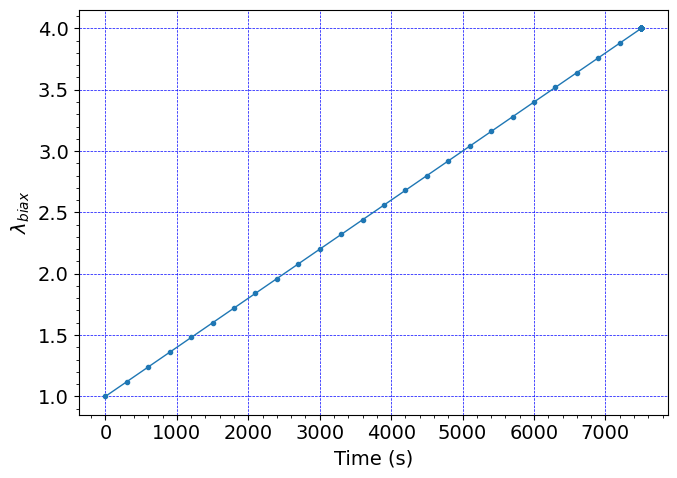

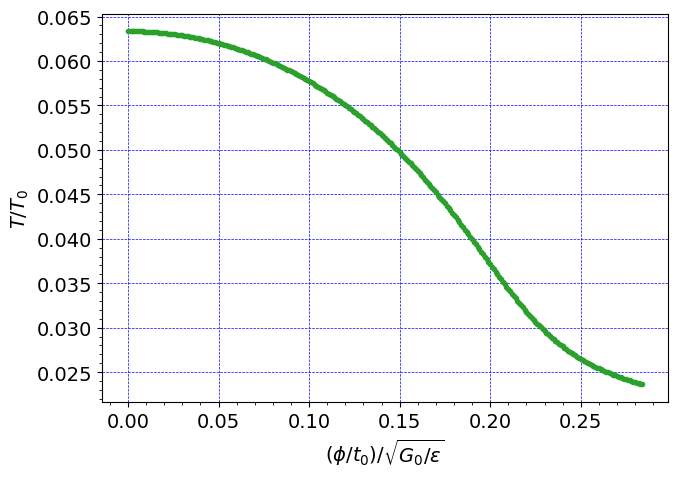

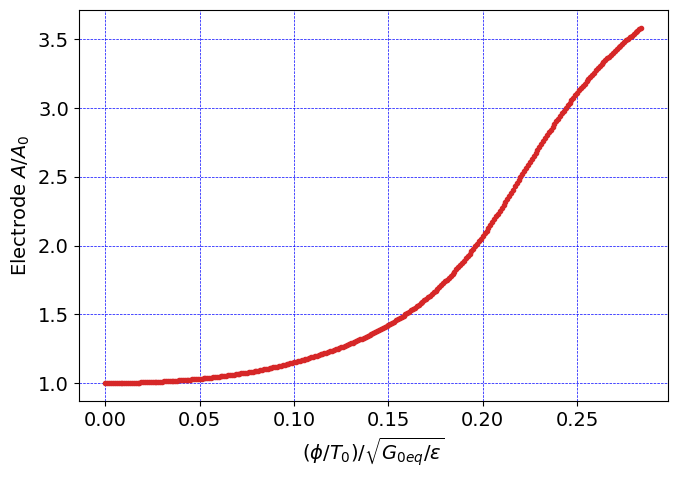

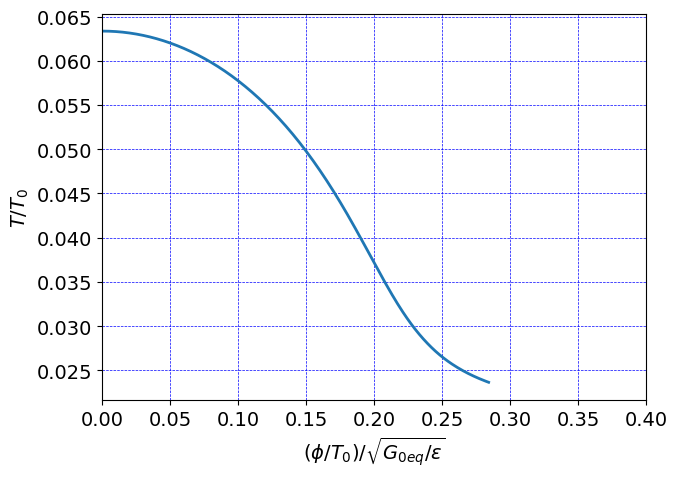

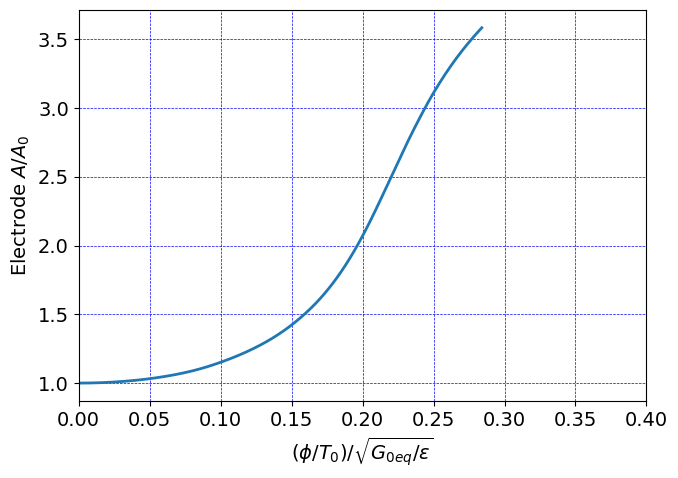

In [50]:
# set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot the macroscoipcally applied biaxial stretch
#
stretch = timeHist0/length + 1.0
stretch = stretch[0:ii]
#
plt.plot(timeHist2[0:ii], stretch, c=colors[0], linewidth=1.0, marker='.')
#plt.scatter(normVolts[iii-1], stretch[iii-1], c='k', marker='x', s=100)
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax = plt.gca()
#
ax.set_ylabel(r'$\lambda_{biax}$')
#ax.set_ylim([0.2,1.1])
# ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#
ax.set_xlabel(r'Time (s)')
#ax.set_xlim([0,1.65])
#ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
# plt.savefig("results/AX_prestretch.png", dpi=600)




plt.figure()
# Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# versus stretch in the thickness direction, only for the actuation step.
#
normVolts = timeHist1/(thickness * np.sqrt(float(Geq_0)/float(vareps))) 
normVolts = normVolts[np.where(timeHist2>=step1_time)]
#
stretch = timeHist4/thickness + 1.0
stretch = stretch[np.where(timeHist2>=step1_time)]
#
plt.plot(normVolts, stretch, c=colors[2], linewidth=1.0, marker='.')
#plt.scatter(normVolts[iii-1], stretch[iii-1], c='k', marker='x', s=100)
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax = plt.gca()
#
ax.set_ylabel(r'$T/T_0$')
#ax.set_ylim([0.2,1.1])
# ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#
ax.set_xlabel(r'$(\phi/t_0)  /  \sqrt{G_{0} / \varepsilon} $')
#ax.set_xlim([0,1.65])
#ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
# plt.savefig("results/AX_prestretch_thinning.png", dpi=600)






plt.figure()
# Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# versus relative area stretch.
#
AreaStrainAbs = (timeHist3**2)/(electrodeRad**2) 
AreaStrainAbs = AreaStrainAbs[np.where(timeHist2>=step1_time)]
#
plt.plot(normVolts, AreaStrainAbs, c=colors[3], linewidth=1.0, marker='.')
#plt.scatter(normVolts[iii-1], stretch[iii-1], c='k', marker='x', s=100)
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax = plt.gca()
#
# ax.set_ylim([1.0,5.0])
# ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#
ax.set_ylabel(r'Electrode $A/A_0$')
ax.set_xlabel(r'$(\phi/T_0)  /  \sqrt{G_{0eq} / \varepsilon} $')

# plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
# plt.savefig("results/AXI_prestretch_areaStretch.png", dpi=600)






plt.figure()
# Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# versus stretch in the thickness direction, only for the actuation step.
#
normVolts = timeHist1/(thickness * np.sqrt(float(Geq_0)/float(vareps))) 
normVolts = normVolts[np.where(timeHist2>=step1_time)]
#
stretch = timeHist4/thickness + 1.0
stretch = stretch[np.where(timeHist2>=step1_time)]
#
plt.plot(normVolts, stretch, c=colors[0], linewidth=2.0)
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlim([0,0.4])
# ax.set_ylim([0.2,1.1])
plt.ylabel(r'$T/T_0$')
plt.xlabel(r'$(\phi/T_0)  /  \sqrt{G_{0eq} / \varepsilon} $')


# plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/AX_prestretch_thinning.png", dpi=600)






plt.figure()
# Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# versus relative area stretch.
#
AreaStrainAbs = (timeHist3**2)/(electrodeRad**2) 
AreaStrainAbs = AreaStrainAbs[np.where(timeHist2>=step1_time)]
#
plt.plot(normVolts, AreaStrainAbs, c=colors[0], linewidth=2.0)
plt.grid(linestyle="--", linewidth=0.5, color='b')
#
plt.xlim([0,0.4])
# ax.set_ylim([1.0,5.0])
#
plt.ylabel(r'Electrode $A/A_0$')
plt.xlabel(r'$(\phi/T_0)  /  \sqrt{G_{0eq} / \varepsilon} $')
#


fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/AXI_prestretch_areaStretch.png", dpi=600)


# Saving data and making plots below, not part of the actual simulation, just for the plots in the book

In [51]:
# np.savetxt('MembraneNoPrestretch.csv', np.vstack((normVolts,stretch,AreaStrainAbs)).T, delimiter=',')
# np.savetxt('MembranePrestretch4.csv', np.vstack((normVolts,stretch,AreaStrainAbs)).T, delimiter=',')

In [52]:
# # retrieve data from prior runs
# NoPre = np.genfromtxt('MembraneNoPrestretch.csv', delimiter=',')
# Pre4 = np.genfromtxt('MembranePrestretch4.csv', delimiter=',')


# plt.figure()
# # Plot the normalized dimensionless quantity for $\phi$ used in Wang et al. 2016
# # versus relative area stretch.
# #
# plt.plot(Pre4[:,0], Pre4[:,2], c=colors[0], linewidth=2.0, label=r'$\lambda_\text{pre}=4$')
# plt.plot(NoPre[:,0], NoPre[:,2], c=colors[1], linewidth=2.0, label=r'$\lambda_\text{pre}=1$')
# plt.grid(linestyle="--", linewidth=0.5, color='b')
# #
# plt.xlim([0,0.4])
# # ax.set_ylim([1.0,5.0])
# #
# plt.ylabel(r'Electrode $A/A_0$')
# plt.xlabel(r'$(\phi/T_0)  /  \sqrt{G_{0eq} / \varepsilon} $')
# #
# plt.legend(loc="upper left")


# fig = plt.gcf()
# fig.set_size_inches(7,5)
# plt.tight_layout()
# plt.savefig("results/AXI_prestretch_areaStretch_comparison.png", dpi=600)